In [81]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (6).json


{'kaggle.json': b'{"username":"parkjeongyeol","key":"c69d9ceac78f62b7c3562530bc416732"}'}

In [82]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                                  deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                         2030-07-01 23:59:00  Getting Started     Prizes         63           False  
gan-getting-started                                  2030-07-01 23:59:00  Getting Started     Prizes        149           False  
tpu-getting-started                                  2030-06-03 23:59:00  Getting Started  Knowledge        227           False  
digit-recognizer                                     2030-01-01 00:00:00  Getting Started  Knowledge       1594           False  
titanic                                              2030-01-01 00:00:00  Getting Started  Knowledge      50547            True  
house-prices-advanced-regression-techniques          2030-01-01 00:00:00  Getting Started 

In [83]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

skin-cancer-mnist-ham10000.zip: Skipping, found more recently modified local copy (use --force to force download)


In [84]:
!unzip skin-cancer-mnist-ham10000.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_

## Data Description

각 이미지에 대한 이진 대상을 예측하고 있습니다. 모델은 이미지의 병변이 악성(표적)일 확률(부동 소수점)을 0.0과 1.0 사이에서 예측해야 합니다. 훈련 데이터 train.csv에서 값 0은 양성, 1은 악성을 나타냅니다.

- image_name - 고유 식별자, 관련 DICOM 이미지의 파일 이름을 가리킵니다.
- patient_id - 고유한 환자 식별자
- sex  - 환자의 성별(알 수 없는 경우 비어 있음)
- age_approx - 이미징 시 대략적인 환자 나이
- anatom_site_general_challenge - 이미지 사이트의 위치
- diagnosis  - 자세한 진단 정보(train only)
- benign_malignant - 영상화된 병변의 악성 지표
- target - 대상 변수의 이진화된 버전

In [85]:
import os, cv2, itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# pytorch libraries
import torch
from torch import optim, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
plt.style.use('ggplot')

In [86]:
# data_dir = '/content/'

# all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
# imageid_path_dict = {os.path.splitext(os.path.basename(x))[0] : x for x in all_image_path}

# lession_type_dict = {
#     'nv': 'Melanocyic nevi (nv)',
#     'mel': 'Melanoma (mel)',
#     'bkl': 'Benign keratosis-like lesions (bkl)',
#     'bcc': 'Basal cell carcinoma (bcc)',
#     'akiec': 'Actinic keratoses (akiec)',
#     'vasc': 'Vascular lesions (vasc)',
#     'df': 'Dermatofibroma (df)'
# }

# label_mapping = {
#        0: 'nv',
#     1: 'mel',
#     2: 'bkl',
#     3: 'bcc',
#     4: 'akiec',
#     5: 'vasc',
#     6: 'df'
# }

# reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [87]:
# data = pd.read_csv(data_dir + 'HAM10000_metadata.csv')

In [88]:
# data.head()

In [89]:
# # Adding cell_type and image_path columns
# data['cell_type'] = data['dx'].map(lession_type_dict.get)
# data['path'] = data['image_id'].map(imageid_path_dict.get)

In [90]:
# data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [91]:
# data.head()

In [92]:
# # 그래프를 그려서 확인해보자.
# fig, ((ax1, ax2),( ax3, ax4)) = plt.subplots(ncols = 2, nrows = 2, figsize = (16,8))
# # target변수의 불균형이 심한 것으로 보인다.
# sns.countplot(data['dx'], ax = ax1)
# sns.countplot(data['dx_type'], ax = ax2)
# # 나이는 5살 간격으로 끊어져 있다.
# sns.countplot(data['age'], ax = ax3)

# # unKnown -> 아마 데이터의 결측치가 아닐까 싶다.
# sns.countplot(data['sex'],  ax = ax4)

In [93]:
# data.info()

In [94]:
# data.isnull().sum()

In [95]:
# # 어떤 방식으로 채워줄지 모르겠어서 dropna를 사용한다~
# data = data.fillna(data['age'].mean())

# # 나이가 5.0, 10.0 이렇게 되어 있는 부분을 정수로 바꿔준다.
# data['age'] = data['age'].astype('int')

In [96]:
# data.head()

In [97]:
# # 나이는 5를 기준으로 끊어져 있다.
# data['age'].unique()

In [98]:
# for i in ['dx','dx_type','age','sex','localization','cell_type']:
#   print(f'***************************** {i} ***************************')
#   print(data[i].unique())
#   print()

In [99]:
# # 데이터의 target을 만들어 준다.
# data['label'] = data['dx'].map(reverse_label_mapping.get)

In [100]:
# data.columns

In [101]:
# # 데이터의 필요없는 부분들을 제외하고 분석을 진행한다.
# data = data.drop(['lesion_id','image_id','dx','path'], axis = 1)

In [102]:
# data.head()

# ML modeling

In [103]:
# data.info()

In [104]:
# # 패키지 불러오기
# from sklearn.multiclass import OneVsRestClassifier
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split

# # label이 int형태로 되어있기 때문에 
# data['label'] = data['label'].astype('str')

In [105]:
# dummy = pd.get_dummies(data = data, columns = ['dx_type','age','sex','localization','cell_type']).drop('image_pixel', axis = 1)
# dummy

In [106]:
# # image_pixel = (28,28,3) -> 하나의 사진에 2352개의 숫자가 들어가 있다.
# image_data = data[['image_pixel','label']]

# image_data['image_pixel'] = image_data['image_pixel'].apply(lambda x: np.array(x).reshape(1,2352))

# ML_data = pd.DataFrame([])
# for i in image_data['image_pixel']:
#   i = pd.DataFrame(i)
#   ML_data = pd.concat([ML_data, i], axis = 0)

# ML_data = ML_data.reset_index(drop = True)
# ML_data['label'] = image_data['label']

# # 머신러닝 부분에서 더미화 한 부분을 사용한다면 결과과 더 좋아질 것이라고 예상한다.

In [107]:
# 이 부분이 좀 오래 걸리는 것 같다... ㅎㅎ
# ML_data = pd.concat([ML_data, dummy], axis = 1)

In [108]:
# X_train.info()

In [109]:
# from sklearn.preprocessing import LabelBinarizer
# target = ML_data['label']


# target = LabelBinarizer().fit_transform(target)
# from xgboost import XGBClassifier

# # 머신러닝 수행하기
# X_train, X_test, y_train, y_test = train_test_split(ML_data.drop('label', axis = 1), ML_data['label'] ,test_size = 0.2, random_state = 42)
# y_pred = OneVsRestClassifier(XGBClassifier(random_state = 42)).fit(X_train, y_train).predict(X_test)

# # confusion matrix 활용하기
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_pred)

In [110]:
# acc 0.72가 나오게 된다.
# np.mean(y_test == y_pred)

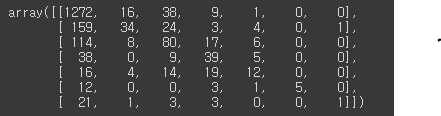

- acc -> 0.7243975903614458

# DL modeling

In [111]:
# # 딥러닝 모델을 설계할 때 활용하는 장비 확인
# if torch.cuda.is_available():
#   DEVICE = torch.device('cuda')
# else:
#   DEVICE = torch.device('cpu')

# print('Using PyTorch version :', torch.__version__, 'Device :', DEVICE)

In [112]:
# data['image_pixel'] = data['image_pixel'].apply(lambda x: np.array(x).reshape(1,28*28*3))

# image_data = pd.DataFrame([])
# for i in data['image_pixel']:
#   i = pd.DataFrame(i)

#   image_data = pd.concat([image_data, i], axis = 0)

# image_data

In [113]:
# image_data = image_data.reset_index(drop = True)

## 데이터 불균형 해결하기

In [114]:
# from imblearn.over_sampling import SMOTE
# # 데이터 나눠주기
# X_train, X_test, y_train, y_test = train_test_split(image_data,data['label'], test_size = 0.1, random_state = 42)

# # X_train = X_train.values.tolist()
# # 데이터의 불균형을 해결해 주기 전
# print(data['label'].value_counts())

# # SMOTE 방법을 이용해서 불균형 해결하기
# smote = SMOTE(random_state = 42)
# X_train, y_train = smote.fit_sample(X_train, y_train)

# # 데이터 불균형을 해결한 후
# 불균형확인 = pd.DataFrame(y_train, columns = ['y_train'])
# print(불균형확인['y_train'].value_counts())

## Modeling

In [115]:
# # image scaling
# image_mean = X_train.mean()
# image_std = X_train.std()

# X_train = (X_train-image_mean)/image_std
# X_test = (X_test-image_mean)/image_std

In [116]:
# np.array(X_test)

In [117]:
# # 패키지 불러오기
# import tensorflow as tf
# import keras
# from keras.utils.np_utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
# from keras import backend as K

# # 데이터 (28,28,3)으로 바꿔주기
# X_train = X_train.reshape(-1, 28,28,3)
# X_test = np.array(X_test).reshape(-1, 28,28,3)

# y_train = to_categorical(y_train, num_classes = 7)
# y_test = to_categorical(y_test, num_classes = 7)

In [118]:
# input_shape = (28,28,3)

# model = Sequential()
# model.add(Conv2D(64, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Dropout(0.3))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(512, activation = 'relu'))
# model.add(Dense(256, activation = 'relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation = 'relu'))
# model.add(Dense(7, activation='softmax'))

In [119]:
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=['accuracy'])

In [120]:
# print(model.summary())

In [121]:
# batch_size = 28
# epochs = 50

# history = model.fit(X_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(X_test, y_test))

# score = model.evaluate(X_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [122]:
# y_pred = model.predict(X_test)

# y_pred_classes = np.argmax(y_pred, axis = 1)

# y_true = np.argmax(y_test, axis = 1)

# confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# print(confusion_mtx)

- Machine learning 보단 더 좋은 결과를 보인다.

- 데이터를 증강한 이유는 데이터의 불균형으로 다른 데이터를 못 맞출까봐 였는데 그런 부분은 이 데이터에 없다고 판단한다.(2column과 3번째 마지막 column은 맞춘수보다 못 맞춘수가 더 많기 때문이다.)
- 과적합이 너무 많이 일어난다. 그 이유는 SMOTE를 사용해서 그렇다고 생각한다.
- 그러면 우리는 SMOTE를 사용하지 않고 해준다면 어떨까?

## 데이터 증강을 하지 않은 상태로 분석 진행하기

In [123]:
# # 데이터 나눠주기
# X_train, X_test, y_train, y_test = train_test_split(image_data, data['label'], test_size = 0.1, random_state = 42)

# # 데이터 scaling
# mean = np.array(X_train).mean()
# std = np.array(X_train).std()

# X_train = (np.array(X_train) - mean)/std
# X_test = (np.array(X_test) -mean)/std

# # target value categorical
# y_train = to_categorical(y_train, num_classes = 7)
# y_test = to_categorical(y_test, num_classes = 7)

# # Data reshape
# X_train = X_train.reshape(-1,28,28,3)
# X_test = X_test.reshape(-1,28,28,3)

In [124]:
# input_shape = (28,28,3)

# model = Sequential()
# model.add(Conv2D(64, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Dropout(0.3))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(512, activation = 'relu'))
# model.add(Dense(256, activation = 'relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation = 'relu'))
# model.add(Dense(7, activation='softmax'))

In [125]:
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=['accuracy'])

In [126]:
# batch_size = 28
# epochs = 50

# history = model.fit(X_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(X_test, y_test))

# score = model.evaluate(X_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [127]:
# y_pred = model.predict(X_test)

# y_pred_classes = np.argmax(y_pred, axis = 1)

# y_true = np.argmax(y_test, axis = 1)

# confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# print(confusion_mtx)

- SMOTE를 사용한 방법과 못 맞춘 비율이 비슷하게 나타나고 있다.

- 심지어 마지막 column은 훨씬 좋은 성과를 내고 있다.

- 그러므로 이번 데이터에서는 SMOTE나 데이터 증강 부분을 생각하지 않고 분석을 하는 것이 좋을 것 같다.

- CNN 모델에서는 좋은 성능을 내지 못한다고 생각한다.

- pytorch를 이용하여 모델을 구축하는 법을 내일부터 공부하기로 하자.

- 그때 그떄 다르긴하지만 SMOTE를 썼을 떄 나는 결과가 더 안좋게 나온다 그러므로 사용하지 않고 진행하도록 한다.

## Pytorch

In [128]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import torch
# from torch import nn
# import torch.nn.functional as F
# from torch.autograd import Variable
# from torch.optim import Adam
# from tqdm import tqdm_notebook
# import seaborn as sns
# from torch.utils.data import TensorDataset, DataLoader

In [129]:
# # 이미지 분석을 진행하기 위해서 이미지와 label만 가져온다.
# copy_data = data[['image_pixel','label']].copy()

# # train과 test로 나눈다.
# train = copy_data.sample(frac = 0.8)
# test = copy_data[~copy_data.isin(train)].dropna().reset_index(drop = True)

# # image_pixel을 28 * 28 * 3의 shape으로 맞춰준다.
# train['image_pixel'] = train['image_pixel'].apply(lambda x:x.reshape(28,28,3))
# test['image_pixel'] = test['image_pixel'].apply(lambda x:x.reshape(28,28,3))

# # label의 데이터를 int형태로 변경한다.
# train['label'] = pd.to_numeric(train['label'].values)
# test['label'] = pd.to_numeric(test['label'].values)

# # train과 test를 28 * 28 * 3으로 만들어 준다.
# train_data = np.concatenate([im for im in train['image_pixel']]).reshape(-1, 28, 28, 3)
# test_data = np.concatenate([im for im in test['image_pixel']]).reshape(-1, 28, 28, 3)

# # train 데이터 torch 형태로 변경
# train_data = torch.from_numpy(train_data).float()
# train_target = torch.from_numpy(train['label'].values).long()

# train_dataset = TensorDataset(train_data, train_target)

# # test 데이터 torch 형태로 변경
# test_data = torch.from_numpy(test_data).float()
# test_target = torch.from_numpy(test['label'].values).long()

# test_dataset = TensorDataset(test_data, test_target)

- 지금 shape error가 계속 발생하는 것을 보면 shape을 28,28,3으로 맞춰주는 것보다 캐글 코딩에 있는 방법으로 다르게 바꿔주는 것이 나은가에 대해서 고민중이다.

In [130]:
# class Net(nn.Module):
#   def __init__(self):
#     super(Net, self).__init__()

#     self.batch = nn.BatchNorm2d(2)

#     self.conv1 = nn.Conv2d(2, 32, kernel_size = 2, padding = 1)

#     self.pool = nn.MaxPool2d(2,2)

#     self.conv2 = nn.Conv2d(32, 64, kernel_size = 2, padding = 1)

#     self.fc1 = nn.Linear(64*18*18, 120)

#     self.fc2 = nn.Linear(120, 64)

#     self.fc3 = nn.Linear(64, 7)

#   def forward(self, x):
#     x = self.batch(x)
#     x = self.pool(F.relu(self.conv1(x)))
#     x = self.pool(F.relu(self.conv2(x)))

#     # 데이터를 Linear 로 할 수 있게 만든다.
#     x = x.view(x.size(0), -1)

#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     # 왜 이 부분은 relu로 해주지 않는가?
#     x = nn.Softmax(self.fc3(x))

#     return x

In [131]:
# net = Net()

In [132]:
# epochs = 50
# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(net.parameters())

# class AverageMeter(object):
#   def __init__(self, window_size = None):
#     self.length = 0
#     self.test = 0
#     self.avg = 0
#     self.sum = 0
#     self.count = 0
#     self.window_size = window_size

#   def reset(self):
#     self.length = 0
#     self.test = 0
#     self.avg = 0
#     self.sum = 0
#     self.count = 0
#     # window_size는 0으로 만든다면 변수를 다시 받아야하기 때문에 0으로 초기화 시키지 않는다.

#   def update(self, test, n = 1):
#     if self.window_size and (self.count >= self.window_size):
#       self.reset()

#     self.test = test
#     self.sum += test*n
#     self.count += n
#     self.avg = self.sum/self.count

  
# def accuracy(y_true, y_pred):
#   y_true = y_true.float()
#   o, y_pred = torch.max(y_pred, dim = -1)
#   return (y_pred.float() == y_true).float().mean()

# def fit(train, test, epochs, batch_size):
#   #  train 데이터는 {}개 test 데이터는 {}개 
#   print('train on {} images test on {} images'.format(len(train), len(test)))

#   train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
#   test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

#   for epoch in tqdm_notebook(range(epochs), total = epochs):
#     running_loss = AverageMeter()
#     running_accuracy = AverageMeter()
#     test_loss_meter = AverageMeter()
#     test_acc_meter = AverageMeter()
#     pbar = tqdm_notebook(train_loader, total = len(train_loader))

#     for data, target in pbar:
#       data, target = Variable(data), Variable(target)
#       output = net(data)
#       loss = criterion(output, target)
#       acc = accuracy(target.data, output.data)
#       running_loss.update(loss.data)
#       running_accuracy.update(acc)
#       pbar.set_description('{loss : {.4f} | acc : {:4f}'.format(runniing_loss.avg, running_accuracy.avg))

#       optimizer.zero_grad()
#       loss.backward()
#       optimizer.step()

#     print('loss : {:.4f} | acc : {:.4f}'.format(running_loss.avg, running_accuracy.avg))

#     for test_data, test_target in test_loader:
#       test_data, test_target = Variable(test_data), Variable(test_target)
#       output = net(test_data)
#       test_loss = criterion(output, test_target)
#       test_acc = accuracy(test_target.data, output.data)
#       test_loss_meter.update(test_loss.data)
#       test_acc_meter.update(test_acc)

#     pbar.set_description('[loss : {:.4f} | acc : {:.4f} | vloss : {:.4f} | vacc : {:.4f}'.format(running_loss.avg, running_accuracy.avg, val_loss_meter_avg, val_acc_meter.avg))

#     print('[loss : {:.4f} | acc : {:.4f} | vloss : {:.4f} | vacc : {:.4f}]'.format(running_loss.avg, running_accuracy.avg, val_loss_meter.avg, val_acc_meter.avg))

In [133]:
# fit(train_dataset, test_dataset, 50, 32)

In [134]:
# Eli5 -> 블랙박스인 딥러닝을 설명하기 위해서 사용하는 툴 나중에 확인해 볼 것

# RGB를 기준으로 Standard scaler를 해준 이후

In [135]:
df = pd.read_csv('/content/hmnist_28_28_RGB.csv')

target = df['label']
data = df.iloc[:,:-1]

final_Lst = []
for i in data.index:
  Lst = []
  Lst.append(data.loc[i,:].values)

  final_Lst.append(Lst)

image_data = np.array(final_Lst).reshape(-1,28,28,3)

image_data = image_data.astype('float')

mean_value = []
std_value = []
for i in range(3):
  RGB = image_data[:,:,:,i].ravel() # 데이터를 평평하게 만든다.

  image_data[:,:,:,i] = (image_data[:,:,:,i] - RGB.mean())/RGB.std()

image_data

array([[[[-0.07664671,  0.35765664,  1.11332941],
         [ 0.00792499,  0.40979205,  1.08988952],
         [ 0.06430611,  0.38372435,  0.92581028],
         ...,
         [-0.04845614,  0.12304727,  0.17573375],
         [ 0.06430611,  0.38372435,  0.41013267],
         [-0.02026558,  0.33158893,  0.33981299]],

        [[ 0.06430611,  0.592266  ,  1.32428843],
         [ 0.17706837,  0.54013059,  1.20708898],
         [ 0.20525893,  0.54013059,  1.11332941],
         ...,
         [-0.02026558,  0.20125039,  0.08197419],
         [ 0.09249668,  0.48799517,  0.48045234],
         [-0.07664671,  0.35765664,  0.50389223]],

        [[ 0.06430611,  0.40979205,  1.11332941],
         [ 0.09249668,  0.38372435,  0.92581028],
         [ 0.20525893,  0.43585976,  1.06644963],
         ...,
         [-0.02026558,  0.25338581,  0.15229386],
         [ 0.12068724,  0.5661983 ,  0.73829115],
         [-0.02026558,  0.43585976,  0.69141136]],

        ...,

        [[-0.02026558,  0.46192747,  1

In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_data, target, test_size = 0.2, random_state = 42)

print(X_train.shape, X_test.shape)

(8012, 28, 28, 3) (2003, 28, 28, 3)


In [137]:
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
import tensorflow as tf

## CNN

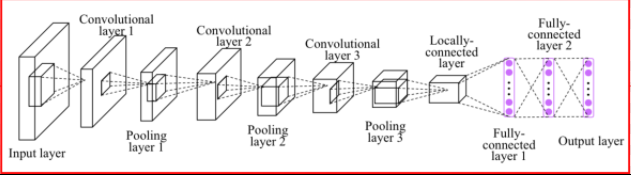

In [138]:
input_shape = (28,28,3)

# CNN 모델 생성
model = Sequential()
model.add(Conv2D(32, kernel_size = (5,5), padding = 'same', activation = 'relu',input_shape = input_shape))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# model.add(Conv2D(16, kernel_size = (3,3), padding = 'same', activation = 'relu'))
# model.add(MaxPool2D(pool_size = (2,2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(7, activation = 'softmax'))

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)             

In [139]:
model.compile(optimizer = Adam(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 50, batch_size = 28, validation_data = (X_test, y_test))

Epoch 1/50
287/287 [==============================] - 2s 5ms/step - loss: 0.8929 - accuracy: 0.6835 - val_loss: 0.8682 - val_accuracy: 0.7044
Epoch 2/50
287/287 [==============================] - 1s 4ms/step - loss: 0.7915 - accuracy: 0.7132 - val_loss: 0.8057 - val_accuracy: 0.7204
Epoch 3/50
287/287 [==============================] - 1s 4ms/step - loss: 0.7251 - accuracy: 0.7314 - val_loss: 0.8475 - val_accuracy: 0.7019
Epoch 4/50
287/287 [==============================] - 1s 4ms/step - loss: 0.6974 - accuracy: 0.7434 - val_loss: 0.7402 - val_accuracy: 0.7309
Epoch 5/50
287/287 [==============================] - 1s 4ms/step - loss: 0.6545 - accuracy: 0.7561 - val_loss: 0.7100 - val_accuracy: 0.7464
Epoch 6/50
287/287 [==============================] - 1s 4ms/step - loss: 0.6377 - accuracy: 0.7640 - val_loss: 0.7035 - val_accuracy: 0.7399
Epoch 7/50
287/287 [==============================] - 1s 4ms/step - loss: 0.5922 - accuracy: 0.7790 - val_loss: 0.6964 - val_accuracy: 0.7514
Epoch 

In [140]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
# RGB로 scaling을 해줬을 때 75.4%로 가장 좋은 성능을 낸다.
print('CNN accuracy :',np.mean(y_test ==np.argmax(y_pred, axis = 1)))

CNN accuracy : 0.745881178232651


## VGG16

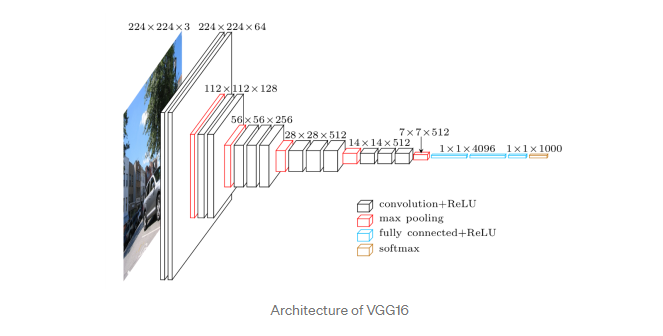

In [141]:
# GPU를 사용하는지 확인해보자.
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [142]:
# 위에 CNN을 수행할 때 해놓은 image_data를 가져온다.
input = 64

# VGG16의 논문에서 나오는 데이터는(-1, 224, 224, 3)의 데이터이기 때문에 우리는 데이터를 resize 시켜주고 가까운 값으로 넣어주도록 하자.
# tf.image.resize를 사용하면 tensorflowshape으로 바뀌면서 train_test_split으로 데이터가 안나눠지기 때문에 .numpy()를 붙여서 numpy로 바꿔준다.
image_data =  tf.image.resize(image_data, size = [input, input], method = 'nearest').numpy()

In [143]:
input_shape = (64, 64, 3) 

# VGG16 run
model = Sequential()
model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(7, activation = 'softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16, 16, 128)      

In [144]:
print(image_data.shape, target.shape)
X_train, X_test, y_train, y_test = train_test_split(image_data, target, test_size = 0.2, random_state = 42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10015, 64, 64, 3) (10015,)
(8012, 64, 64, 3) (2003, 64, 64, 3) (8012,) (2003,)


In [145]:
model.compile(optimizer = Adam(), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/50
251/251 [==============================] - 10s 35ms/step - loss: 1.1175 - accuracy: 0.6568 - val_loss: 0.9967 - val_accuracy: 0.6680
Epoch 2/50
251/251 [==============================] - 9s 34ms/step - loss: 0.9733 - accuracy: 0.6692 - val_loss: 0.9122 - val_accuracy: 0.6715
Epoch 3/50
251/251 [==============================] - 9s 34ms/step - loss: 0.9166 - accuracy: 0.6781 - val_loss: 0.8474 - val_accuracy: 0.6860
Epoch 4/50
251/251 [==============================] - 9s 34ms/step - loss: 0.8502 - accuracy: 0.6907 - val_loss: 0.8736 - val_accuracy: 0.6760
Epoch 5/50
251/251 [==============================] - 9s 34ms/step - loss: 0.8361 - accuracy: 0.6945 - val_loss: 0.8423 - val_accuracy: 0.6950
Epoch 6/50
251/251 [==============================] - 9s 34ms/step - loss: 0.8162 - accuracy: 0.6986 - val_loss: 0.8215 - val_accuracy: 0.6935
Epoch 7/50
251/251 [==============================] - 9s 34ms/step - loss: 0.8033 - accuracy: 0.7062 - val_loss: 0.8230 - val_accuracy: 0.711

In [146]:
# VGG16의 결과물
y_pred = model.predict(X_test)

np.mean(y_test == np.argmax(y_pred, axis = 1))

0.7169246130803795

## ResNet 50